In [8]:
import pandas as pd

In [9]:
covid_data = pd.read_csv('data/covid_data.csv')
display(covid_data.head())

,date,province/state,country,confirmed,deaths,recovered
0,01/22/2020,Anhui,China,1.0,0.0,0.0
1,01/22/2020,Beijing,China,14.0,0.0,0.0
2,01/22/2020,Chongqing,China,6.0,0.0,0.0
3,01/22/2020,Fujian,China,1.0,0.0,0.0
4,01/22/2020,Gansu,China,0.0,0.0,0.0


In [10]:
vaccinations_data = pd.read_csv('data/country_vaccinations.csv')
vaccinations_data = vaccinations_data[
    ['country', 'date', 'total_vaccinations', 
     'people_vaccinated', 'people_vaccinated_per_hundred',
     'people_fully_vaccinated', 'people_fully_vaccinated_per_hundred',
     'daily_vaccinations', 'vaccines']
]
display(vaccinations_data.head())

,country,date,total_vaccinations,people_vaccinated,people_vaccinated_per_hundred,people_fully_vaccinated,people_fully_vaccinated_per_hundred,daily_vaccinations,vaccines
0,Afghanistan,2021-02-22,0.0,0.0,0.0,NaN,NaN,NaN,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi..."
1,Afghanistan,2021-02-23,NaN,NaN,NaN,NaN,NaN,1367.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi..."
2,Afghanistan,2021-02-24,NaN,NaN,NaN,NaN,NaN,1367.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi..."
3,Afghanistan,2021-02-25,NaN,NaN,NaN,NaN,NaN,1367.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi..."
4,Afghanistan,2021-02-26,NaN,NaN,NaN,NaN,NaN,1367.0,"Johnson&Johnson, Oxford/AstraZeneca, Pfizer/Bi..."


**Обьединяем таблицы**

нюансы:
* В covid_data необходимо сперва рассчитать суммарное ежедневное число заболевших во всех провинциях/штатах в каждой стране
* В таблицах не совпадает число стран, а иногда и их названия
* При объединении таблиц по столбцу мы определённо теряем данные (в данной задаче потери незначительны)
* Таблицы имеют разные периоды наблюдений (вакцины появились позже, чем сам вирус). Объединив данные с типом inner, мы можем потерять большое количество наблюдений в таблице covid_data

In [11]:
# Группируем таблицу по дате и названию страны и рассчитываем суммарные показатели по всем регионам. 
# Тем самым переходим от данных по регионам к данным по странам

covid_data = covid_data.groupby(
    ['date', 'country'], 
    as_index=False
)[['confirmed', 'deaths', 'recovered']].sum()

covid_data.head()

,date,country,confirmed,deaths,recovered
0,01/01/2021,Afghanistan,51526.0,2191.0,41727.0
1,01/01/2021,Albania,58316.0,1181.0,33634.0
2,01/01/2021,Algeria,99897.0,2762.0,67395.0
3,01/01/2021,Andorra,8117.0,84.0,7463.0
4,01/01/2021,Angola,17568.0,405.0,11146.0


In [12]:
# Преобразуем даты в формат datetime с помощью функции pd.to_datetime()

covid_data['date'] = pd.to_datetime(covid_data['date'])

In [13]:
# Создадим признак больных на данный момент (active). 
# Для этого вычтем из общего числа зафиксированных случаев число смертей и число выздоровевших пациентов

covid_data['active'] = covid_data['confirmed'] - covid_data['deaths'] - covid_data['recovered']

In [14]:
# Создадим признак ежедневного прироста числа заболевших, умерших и выздоровевших людей. 
# Для этого отсортируем данные по названиям стран, а затем по датам. 
# После этого произведём группировку по странам и рассчитаем разницу между «вчера и сегодня» с помощью метода diff()

covid_data = covid_data.sort_values(by=['country', 'date'])
covid_data['daily_confirmed'] = covid_data.groupby('country')['confirmed'].diff()
covid_data['daily_deaths'] = covid_data.groupby('country')['deaths'].diff()
covid_data['daily_recovered'] = covid_data.groupby('country')['recovered'].diff()

In [15]:
#covid_data.head()
covid_data['date'].max()
#covid_data['date'].min()

Timestamp('2021-05-29 00:00:00')

In [16]:
# В таблице vaccinations_data достаточно будет преобразовать столбцы в формат datetime

vaccinations_data['date'] = pd.to_datetime(vaccinations_data['date'])
vaccinations_data['date'].max()

Timestamp('2021-09-06 00:00:00')

In [17]:
covid_df = covid_data.merge(
    vaccinations_data,
    on=['date','country'],
    how='left'
    )
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86785 entries, 0 to 86784
Data columns (total 16 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   date                                 86785 non-null  datetime64[ns]
 1   country                              86785 non-null  object        
 2   confirmed                            86785 non-null  float64       
 3   deaths                               86785 non-null  float64       
 4   recovered                            86785 non-null  float64       
 5   active                               86785 non-null  float64       
 6   daily_confirmed                      86564 non-null  float64       
 7   daily_deaths                         86564 non-null  float64       
 8   daily_recovered                      86564 non-null  float64       
 9   total_vaccinations                   10629 non-null  float64       
 10  people_vac

In [18]:
covid_df['death_rate'] = covid_df['deaths']/covid_df['confirmed'] * 100
covid_df['recovery_rate'] = covid_df['recovered']/covid_df['confirmed'] * 100

#round(covid_df[covid_df['country'] == 'United States']['death_rate'].max(),2)
round(covid_df[covid_df['country'] == 'Russia']['recovery_rate'].mean(),2)

67.06

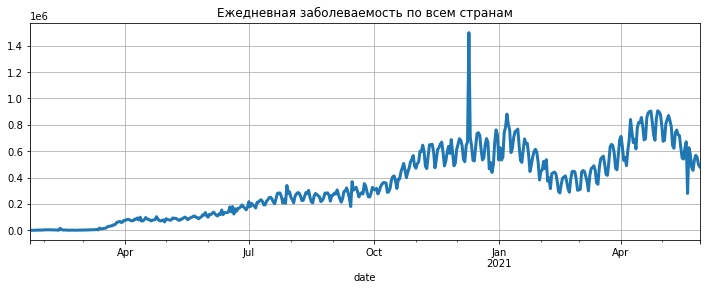

In [19]:
grouped_cases = covid_df.groupby('date')['daily_confirmed'].sum()
grouped_cases.plot(
    kind='line',
    figsize=(12, 4),
    title='Ежедневная заболеваемость по всем странам',
    grid = True,
    lw=3
);

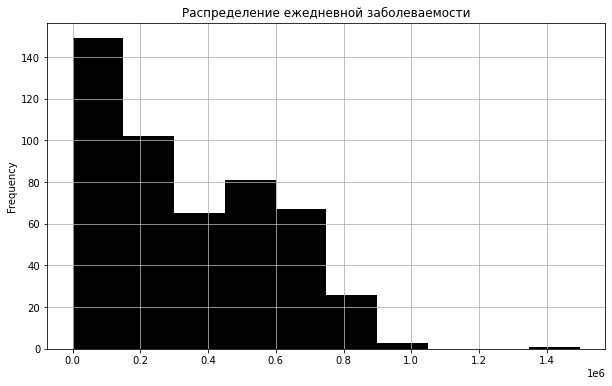

In [20]:
grouped_cases.plot(
    kind='hist',
    figsize=(10, 6),
    title='Распределение ежедневной заболеваемости',
    grid = True,
    color = 'black',
    bins=10
);

<AxesSubplot:xlabel='country'>

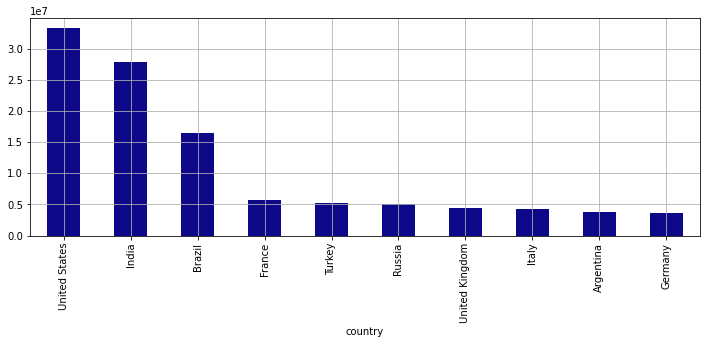

In [21]:
grouped_country = covid_df.groupby(['country'])['confirmed'].last()
grouped_country = grouped_country.nlargest(10)
grouped_country.plot(
    kind='bar',
    grid=True,
    figsize=(12, 4),
    colormap='plasma'
)

<AxesSubplot:xlabel='country'>

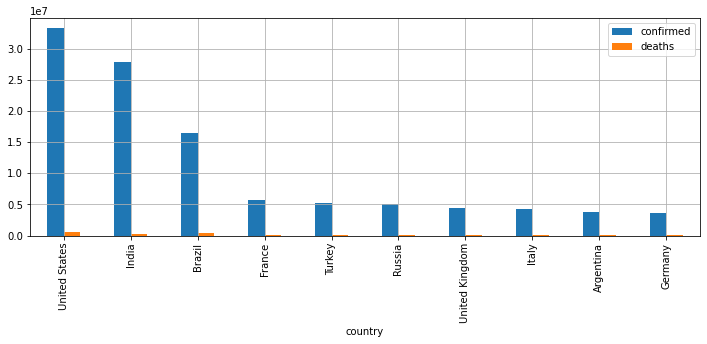

In [22]:
grouped_country = covid_df.groupby(['country'])[['confirmed', 'deaths']].last()
grouped_country = grouped_country.nlargest(10, columns=['confirmed'])
grouped_country.plot( 
    kind='bar', 
    grid=True, 
    figsize=(12, 4), 
)

<AxesSubplot:xlabel='country'>

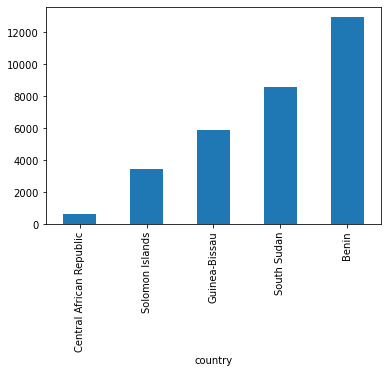

In [23]:
covid_df.groupby(['country'])['total_vaccinations'].last().nsmallest(5).plot(kind='bar')

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

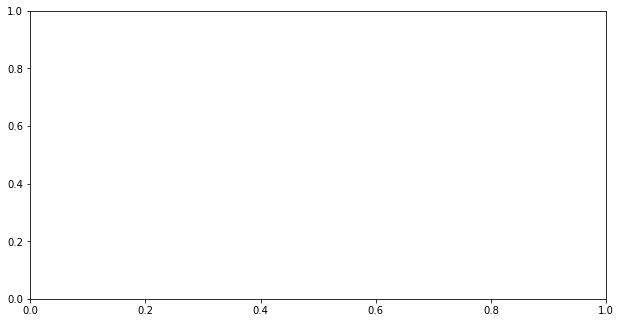

In [25]:
fig = plt.figure(figsize=(8, 4))
axes = fig.add_axes([0, 0, 1, 1])

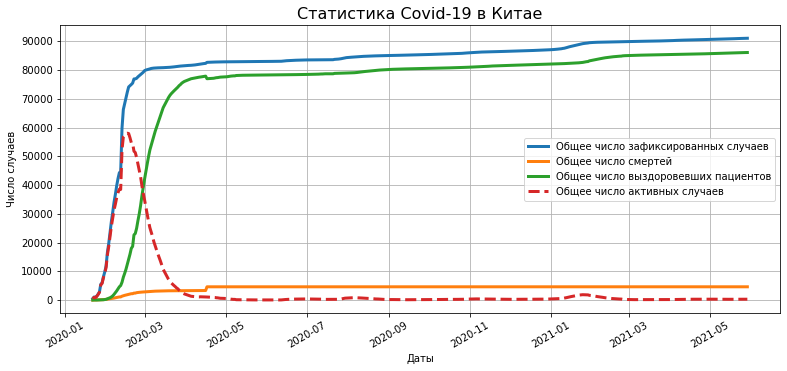

In [26]:
china_data = covid_df[covid_df['country'] == 'China']
china_grouped = china_data.groupby(['date'])[['confirmed', 'active', 'deaths', 'recovered']].sum()

#визуализация графиков
fig = plt.figure(figsize=(10, 4))
axes = fig.add_axes([0, 0, 1, 1])
axes.plot(china_grouped['confirmed'], label='Общее число зафиксированных случаев', lw=3)
axes.plot(china_grouped['deaths'], label='Общее число смертей', lw=3)
axes.plot(china_grouped['recovered'], label='Общее число выздоровевших пациентов', lw=3)
axes.plot(china_grouped['active'], label='Общее число активных случаев', lw=3, linestyle='dashed')

#установка параметров отображения
axes.set_title('Статистика Covid-19 в Китае', fontsize=16)
axes.set_xlabel('Даты')
axes.set_ylabel('Число случаев')
axes.set_yticks(range(0, 100000, 10000))
axes.xaxis.set_tick_params(rotation=30)
axes.grid()
axes.legend();

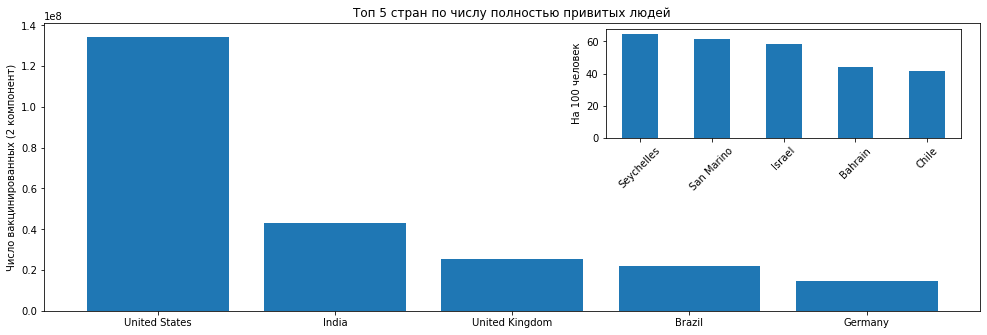

In [27]:
vacc_country = covid_df.groupby('country')['people_fully_vaccinated'].last().nlargest(5)
vacc_country_per_hundred = covid_df.groupby('country')['people_fully_vaccinated_per_hundred'].last().nlargest(5)

#визуализация главного графика
fig = plt.figure(figsize=(13, 4))
main_axes = fig.add_axes([0, 0, 1, 1])
main_axes.bar(x = vacc_country.index, height = vacc_country);
main_axes.set_ylabel('Число вакцинированных (2 компонент)')
main_axes.set_title('Топ 5 стран по числу полностью привитых людей')

#визуализация вспомогательного графика
insert_axes = fig.add_axes([0.6, 0.6, 0.38, 0.38])
insert_axes.bar(x = vacc_country_per_hundred.index, height = vacc_country_per_hundred, width=0.5);
insert_axes.set_ylabel('На 100 человек')
insert_axes.xaxis.set_tick_params(rotation=45)

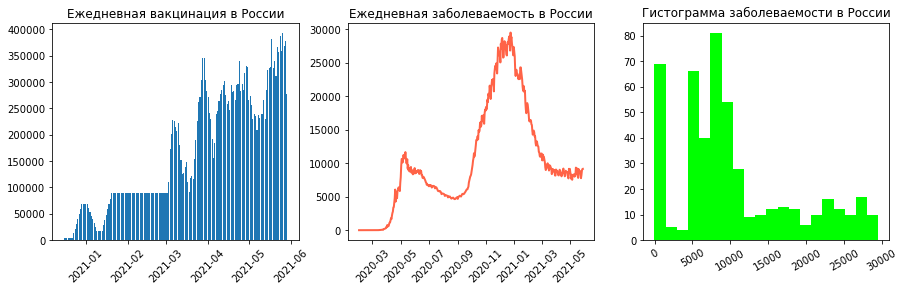

In [28]:
russia_data = covid_df[covid_df["country"] == "Russia"]

# визуализация систем координат
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

# столбчатая диаграмма
axes[0].bar(
    x=russia_data["date"],
    height=russia_data["daily_vaccinations"],
    label="Число вакцинированных",
)
axes[0].set_title("Ежедневная вакцинация в России")
axes[0].xaxis.set_tick_params(rotation=45)

# линейный график
axes[1].plot(
    russia_data["date"],
    russia_data["daily_confirmed"],
    label="Число заболевших",
    color="tomato",
    lw=2,
)
axes[1].set_title("Ежедневная заболеваемость в России")
axes[1].xaxis.set_tick_params(rotation=45)

# гистограмма
axes[2].hist(
    x=russia_data["daily_confirmed"], label=["Число заболевших"], color="lime", bins=20
)
axes[2].set_title("Гистограмма заболеваемости в России")
axes[2].xaxis.set_tick_params(rotation=30)

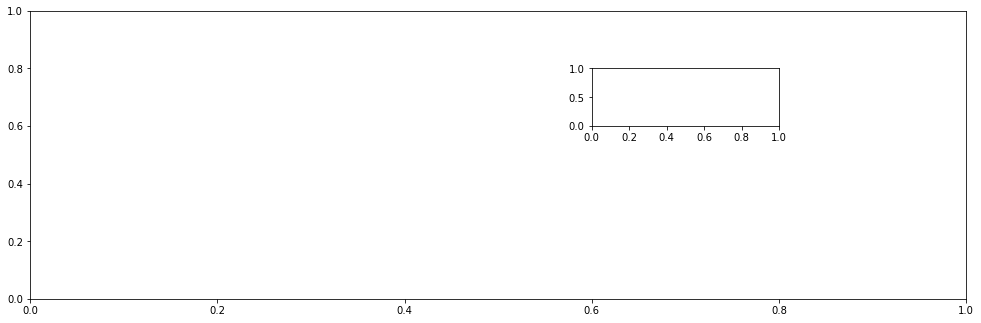

In [29]:
fig = plt.figure(figsize=(13, 4))
main_axes = fig.add_axes([0, 0, 1, 1])
insert_axes = fig.add_axes([0.6, 0.6, 0.2, 0.2])


<BarContainer object of 5 artists>

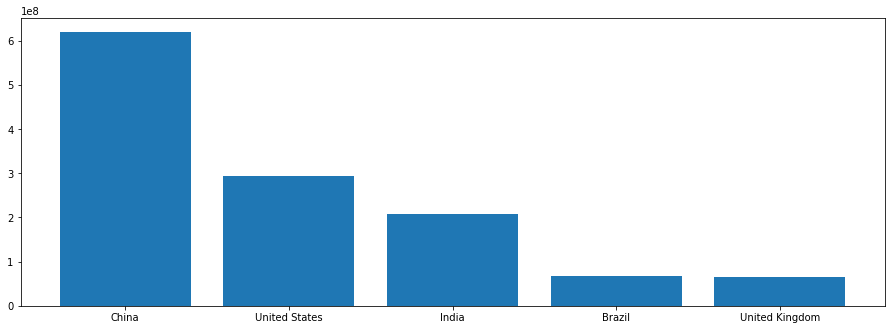

In [30]:
v = covid_df.groupby(['country'])['total_vaccinations'].last().nlargest(5)
fig = plt.figure(figsize=(12, 4))
axes = fig.add_axes([0, 0, 1, 1])
axes.bar(x=v.index,height=v)

In [31]:
import seaborn as sns
print(sns.__version__)

0.11.2


In [32]:
countries = ['Russia', 'Australia', 'Germany', 'Canada', 'United Kingdom']
croped_covid_df = covid_df[covid_df['country'].isin(countries)]

populations = pd.DataFrame([
    ['Canada', 37664517],
    ['Germany', 83721496],
    ['Russia', 145975300],
    ['Australia', 25726900],
    ['United Kingdom', 67802690]
    ],
    columns=['country', 'population']
)
croped_covid_df = croped_covid_df.merge(populations, on=['country'])
croped_covid_df['daily_confirmed_per_hundred'] = croped_covid_df['daily_confirmed'] / croped_covid_df['population'] * 100
croped_covid_df.head()

,date,country,confirmed,deaths,recovered,active,daily_confirmed,daily_deaths,daily_recovered,total_vaccinations,people_vaccinated,people_vaccinated_per_hundred,people_fully_vaccinated,people_fully_vaccinated_per_hundred,daily_vaccinations,vaccines,death_rate,recovery_rate,population,daily_confirmed_per_hundred
0,2020-01-23,Australia,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25726900,NaN
1,2020-01-25,Australia,4.0,0.0,0.0,4.0,4.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,25726900,0.000016
2,2020-01-26,Australia,4.0,0.0,0.0,4.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,25726900,0.000000
3,2020-01-27,Australia,5.0,0.0,0.0,5.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,25726900,0.000004
4,2020-01-28,Australia,5.0,0.0,0.0,5.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,25726900,0.000000


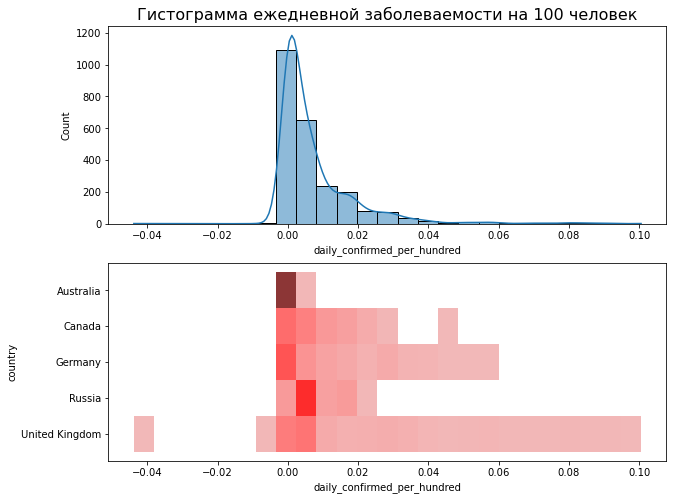

In [33]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8)) # создаём две координатные плоскости с помощью метода subplots
sns.histplot(
    data=croped_covid_df,
    x='daily_confirmed_per_hundred',
    bins=25,
    kde=True,
    ax=axes[0]
);
axes[0].set_title('Гистограмма ежедневной заболеваемости на 100 человек', fontsize=16)
sns.histplot(
    data=croped_covid_df,
    x='daily_confirmed_per_hundred',
    y='country',
    bins=25,
    color='red',
    ax=axes[1]
);

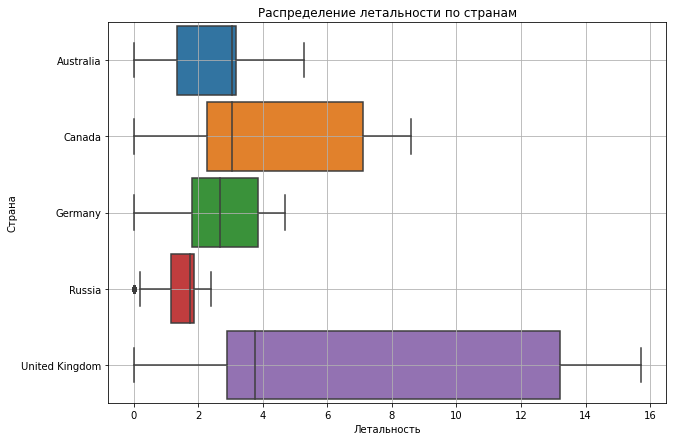

In [34]:
fig = plt.figure(figsize=(10, 7))
boxplot = sns.boxplot(
    data=croped_covid_df,
    y='country',
    x='death_rate',
    orient='h',
    width=0.9
)
boxplot.set_title('Распределение летальности по странам');
boxplot.set_xlabel('Летальность');
boxplot.set_ylabel('Страна');
boxplot.grid()

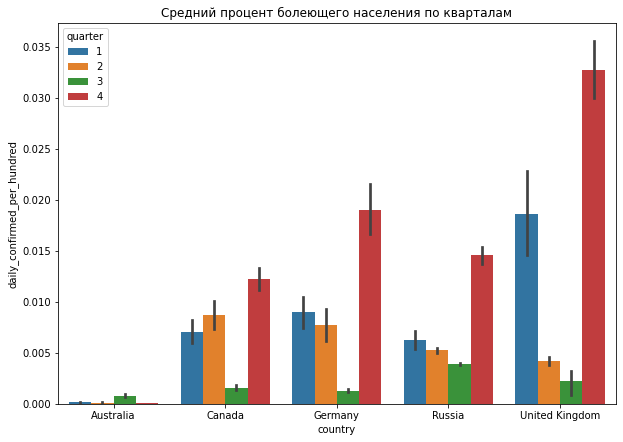

In [35]:
fig = plt.figure(figsize=(10, 7))
croped_covid_df['quarter'] = croped_covid_df['date'].dt.quarter
barplot = sns.barplot(
    data=croped_covid_df,
    x='country',
    y='daily_confirmed_per_hundred',
    hue='quarter',
)
barplot.set_title('Средний процент болеющего населения по кварталам');